In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/onlineretail/OnlineRetail.csv


### Load Packages

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, median_absolute_error

%matplotlib inline


### Load the data

In [3]:
df=pd.read_csv(r"../input/onlineretail/OnlineRetail.csv", encoding="cp1252")


In [5]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


In [6]:
df.shape

(541909, 8)

### Data Clean-Up

**Negative Quantity**

In [7]:
df.loc[df['Quantity'] <= 0].shape

(10624, 8)

In [8]:
df = df.loc[df['Quantity'] > 0]

**Missing CustomerID**

In [9]:
df = df[pd.notnull(df['CustomerID'])]

**Excluding Incomplete Month**

In [10]:
print('Date Range: %s ~ %s' % (df['InvoiceDate'].min(), df['InvoiceDate'].max()))

Date Range: 1/10/2011 10:32 ~ 9/9/2011 9:52


In [11]:
df = df.loc[df['InvoiceDate'] < '2011-12-01']

**Total Sales**

In [13]:
df['Sales'] = df['Quantity'] * df['UnitPrice']

**Per Order Data**

In [14]:

orders_df = df.groupby(['CustomerID', 'InvoiceNo']).agg({
    'Sales': sum,
    'InvoiceDate': max
})

In [15]:
orders_df


Sales       InvoiceDate
CustomerID InvoiceNo                            
12346.0    541431     77183.60   1/18/2011 10:01
12347.0    537626       711.79   12/7/2010 14:57
           542237       475.39   1/26/2011 14:30
           573511      1294.32  10/31/2011 12:25
           581180       224.82   12/7/2011 15:52
...                        ...               ...
18283.0    578262       313.65  11/23/2011 13:27
           579673       223.61  11/30/2011 12:59
           580872       208.00   12/6/2011 12:02
18287.0    570715      1001.32  10/12/2011 10:23
           573167        70.68   10/28/2011 9:29

[8750 rows x 2 columns]

### Data Analysis

In [16]:
def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def purchase_duration(x):
    return (x.max() - x.min()).days

def avg_frequency(x):
    return (x.max() - x.min()).days/x.count()

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
purchase_duration.__name__ = 'purchase_duration'
avg_frequency.__name__ = 'purchase_frequency'

In [20]:
orders_df['InvoiceDate']=pd.to_datetime(orders_df['InvoiceDate'])

In [21]:
summary_df = orders_df.reset_index().groupby('CustomerID').agg({
    'Sales': [min, max, sum, groupby_mean, groupby_count],
    'InvoiceDate': [min, max, purchase_duration, avg_frequency]
})

In [22]:
summary_df

Sales                                          \
                 min       max       sum           avg count   
CustomerID                                                     
12346.0     77183.60  77183.60  77183.60  77183.600000   1.0   
12347.0       224.82   1294.32   2706.32    676.580000   4.0   
12348.0       227.44    892.80   1120.24    560.120000   2.0   
12349.0      1757.55   1757.55   1757.55   1757.550000   1.0   
12350.0       334.40    334.40    334.40    334.400000   1.0   
...              ...       ...       ...           ...   ...   
18276.0       335.86    335.86    335.86    335.860000   1.0   
18277.0       110.38    110.38    110.38    110.380000   1.0   
18282.0        77.84     77.84     77.84     77.840000   1.0   
18283.0         1.95    313.65   1292.11    143.567778   9.0   
18287.0        70.68   1001.32   1072.00    536.000000   2.0   

                   InvoiceDate                                        \
                           min                 max purchase_duration   
CustomerID                                                             
12346.0    2011-01-18 10:01:00 2011-01-18 10:01:00                 0   
12347.0    2010-12-07 14:57:00 2011-12-07 15:52:00               365   
12348.0    2010-12-16 19:09:00 2011-01-25 10:42:00                39   
12349.0    2011-11-21 09:51:00 2011-11-21 09:51:00                 0   
12350.0    2011-02-02 16:01:00 2011-02-02 16:01:00                 0   
...                        ...                 ...               ...   
18276.0    2011-10-27 10:54:00 2011-10-27 10:54:00                 0   
18277.0    2011-10-12 15:22:00 2011-10-12 15:22:00                 0   
18282.0    2011-12-02 11:43:00 2011-12-02 11:43:00                 0   
18283.0    2011-01-06 14:14:00 2011-12-06 12:02:00               333   
18287.0    2011-10-12 10:23:00 2011-10-28 09:29:00                15   

                               
           purchase_frequency  
CustomerID                     
12346.0                  0.00  
12347.0                 91.25  
12348.0                 19.50  
12349.0                  0.00  
12350.0                  0.00  
...                       ...  
18276.0                  0.00  
18277.0                  0.00  
18282.0                  0.00  
18283.0                 37.00  
18287.0                  7.50  

[3251 rows x 9 columns]

In [26]:
summary_df.columns = ['_'.join(col).lower() for col in summary_df.columns]

In [27]:
summary_df = summary_df.loc[summary_df['invoicedate_purchase_duration'] > 0]

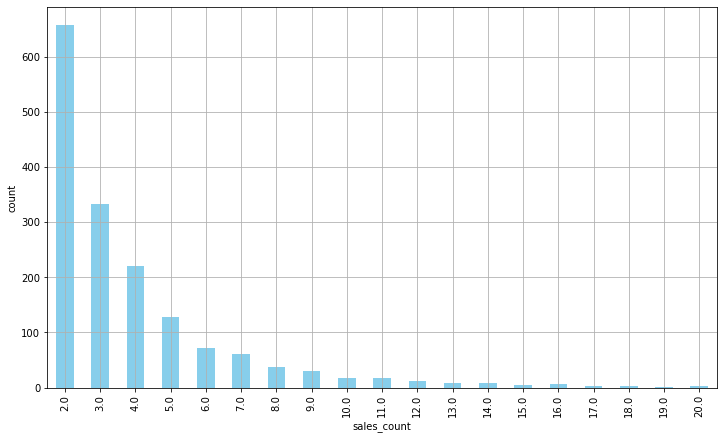

In [28]:
ax = summary_df.groupby('sales_count').count()['sales_avg'][:20].plot(
    kind='bar', 
    color='skyblue',
    figsize=(12,7), 
    grid=True
)

ax.set_ylabel('count')

plt.show()

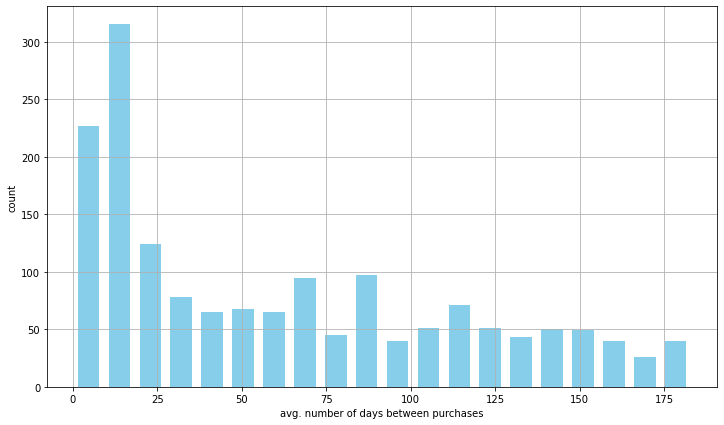

In [29]:
ax = summary_df['invoicedate_purchase_frequency'].hist(
    bins=20,
    color='skyblue',
    rwidth=0.7,
    figsize=(12,7)
)

ax.set_xlabel('avg. number of days between purchases')
ax.set_ylabel('count')

plt.show()

### Predicting 3-Month CLV

#### Data Preparation

In [30]:
clv_freq = '3M'
data_df = orders_df.reset_index().groupby([
    'CustomerID',
    pd.Grouper(key='InvoiceDate', freq=clv_freq)
]).agg({
    'Sales': [sum, groupby_mean, groupby_count],
})

In [31]:
data_df.columns = ['_'.join(col).lower() for col in data_df.columns]

In [32]:
data_df = data_df.reset_index()

In [33]:
date_month_map = {
    str(x)[:10]: 'M_%s' % (i+1) for i, x in enumerate(
        sorted(data_df.reset_index()['InvoiceDate'].unique(), reverse=True)
    )
}

In [34]:
data_df['M'] = data_df['InvoiceDate'].apply(lambda x: date_month_map[str(x)[:10]])
date_month_map


{'2011-12-31': 'M_1', '2011-03-31': 'M_2', '2010-12-31': 'M_3'}

In [35]:
data_df.head(10)

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count,M
0,12346.0,2011-03-31,77183.60,77183.60,1.0,M_2
1,12347.0,2010-12-31,711.79,711.79,1.0,M_3
2,12347.0,2011-03-31,475.39,475.39,1.0,M_2
3,12347.0,2011-12-31,1519.14,759.57,2.0,M_1
4,12348.0,2010-12-31,892.80,892.80,1.0,M_3
5,12348.0,2011-03-31,227.44,227.44,1.0,M_2
6,12349.0,2011-12-31,1757.55,1757.55,1.0,M_1
7,12350.0,2011-03-31,334.40,334.40,1.0,M_2
8,12352.0,2011-03-31,296.50,296.50,1.0,M_2
9,12352.0,2011-12-31,311.73,311.73,1.0,M_1


#### Building Sample Set

In [36]:
features_df = pd.pivot_table(
    data_df.loc[data_df['M'] != 'M_1'], 
    values=['sales_sum', 'sales_avg', 'sales_count'], 
    columns='M', 
    index='CustomerID'
)

In [37]:
features_df.columns = ['_'.join(col) for col in features_df.columns]
features_df.head(3)

,sales_avg_M_2,sales_avg_M_3,sales_count_M_2,sales_count_M_3,sales_sum_M_2,sales_sum_M_3
CustomerID,,,,,,
12346.0,77183.60,NaN,1.0,NaN,77183.60,NaN
12347.0,475.39,711.79,1.0,1.0,475.39,711.79
12348.0,227.44,892.80,1.0,1.0,227.44,892.80


In [38]:
features_df = features_df.fillna(0)
response_df = data_df.loc[
    data_df['M'] == 'M_1',
    ['CustomerID', 'sales_sum']
]

response_df.columns = ['CustomerID', 'CLV_'+clv_freq]


In [39]:
response_df.head(10)

,CustomerID,CLV_3M
3,12347.0,1519.14
6,12349.0,1757.55
9,12352.0,311.73
11,12356.0,58.35
12,12357.0,6207.67
13,12358.0,683.20
15,12359.0,2876.85
16,12360.0,1043.78
19,12362.0,2648.89
20,12364.0,609.38


In [40]:

sample_set_df = features_df.merge(
    response_df, 
    left_index=True, 
    right_on='CustomerID',
    how='left'
)

In [41]:
sample_set_df = sample_set_df.fillna(0)
sample_set_df['CLV_'+clv_freq].describe()

count     1682.000000
mean       920.706231
std       3712.676313
min          0.000000
25%          0.000000
50%        218.835000
75%        745.132500
max      79497.890000
Name: CLV_3M, dtype: float64

### Regression Models

In [42]:
target_var = 'CLV_'+clv_freq
all_features = [x for x in sample_set_df.columns if x not in ['CustomerID', target_var]]

In [43]:
x_train, x_test, y_train, y_test = train_test_split(
    sample_set_df[all_features], 
    sample_set_df[target_var], 
    test_size=0.3
)

#### Linear regression

In [44]:
reg_fit = LinearRegression()
reg_fit.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
reg_fit.intercept_

227.53656034899996

In [46]:
coef = pd.DataFrame(list(zip(all_features, reg_fit.coef_)))
coef.columns = ['feature', 'coef']

coef

,feature,coef
0,sales_avg_M_2,-0.802312
1,sales_avg_M_3,-0.570974
2,sales_count_M_2,-130.463301
3,sales_count_M_3,-259.197597
4,sales_sum_M_2,1.215923
5,sales_sum_M_3,2.099159


### Evaluation

In [48]:
train_preds =  reg_fit.predict(x_train)
test_preds = reg_fit.predict(x_test)

**R^2**

In [49]:
print('In-Sample R-Squared: %0.4f' % r2_score(y_true=y_train, y_pred=train_preds))
print('Out-of-Sample R-Squared: %0.4f' % r2_score(y_true=y_test, y_pred=test_preds))

In-Sample R-Squared: 0.7456
Out-of-Sample R-Squared: 0.1633


**Median Absolute Error**

In [50]:
print('In-Sample MSE: %0.4f' % median_absolute_error(y_true=y_train, y_pred=train_preds))
print('Out-of-Sample MSE: %0.4f' % median_absolute_error(y_true=y_test, y_pred=test_preds))

In-Sample MSE: 277.4823
Out-of-Sample MSE: 276.4211


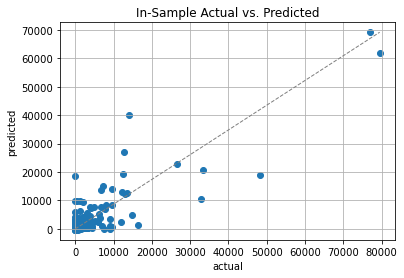

In [51]:
plt.scatter(y_train, train_preds)
plt.plot([0, max(y_train)], [0, max(train_preds)], color='gray', lw=1, linestyle='--')

plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('In-Sample Actual vs. Predicted')
plt.grid()

plt.show()

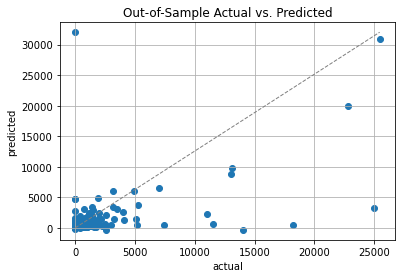

In [52]:
plt.scatter(y_test, test_preds)
plt.plot([0, max(y_test)], [0, max(test_preds)], color='gray', lw=1, linestyle='--')

plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('Out-of-Sample Actual vs. Predicted')
plt.grid()

plt.show()

EOD